## **Google colab**

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  google_colab = True
except:
  google_colab = False

Mounted at /content/drive


In [ ]:
if google_colab:
  import os
  os.system("unzip /content/drive/MyDrive/SSNE/miniprojekt5/trafic_32.zip")
  data_path = "/content/trafic_32"
else:
  data_path = "./trafic_32"

In [ ]:
data_path

'/content/trafic_32'

## **Imports**

In [ ]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## **Data**

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.ImageFolder(root=data_path, transform=transform)
test_dataset = datasets.ImageFolder(root=data_path, transform=transform)

train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

In [ ]:
train_data, train_labels = next(iter(train_loader))
train_data[0].size()

torch.Size([3, 32, 32])

### **Data prep**

In [ ]:
import os
from os.path import join as os_join 

classes_dir = os.listdir(data_path)
classes_amount = [len(os.listdir(os_join(data_path, dir_name))) for dir_name in classes_dir]
assert len(classes_amount) == len(classes_dir)
print(torch.tensor(classes_amount))


tensor([ 420,  630,  600,  240, 2160, 1410,  450,  240, 1410,  780,  210, 1200,
        1980, 1110,  330,  420,  540, 1470,  270,  300,  270,  240,  210, 1440,
        2220,  390,  689,  240, 2010, 1200,  510,  390,  780, 1500,  360,  360,
        1860, 1320, 2070, 2250, 2100,  420,  210])


In [ ]:
classes_weights = torch.tensor([round( 1 - (class_amount / sum(classes_amount)) * 10, 2) for class_amount in classes_amount])
classes_weights = torch.log(classes_weights * 10)
classes_weights

tensor([2.1861, 2.1282, 2.1401, 2.2407, 1.5041, 1.8563, 2.1861, 2.2407, 1.8563,
        2.0794, 2.2513, 1.9315, 1.6094, 1.9741, 2.2192, 2.1861, 2.1518, 1.8405,
        2.2300, 2.2192, 2.2300, 2.2407, 2.2513, 1.8405, 1.4586, 2.1972, 2.1041,
        2.2407, 1.5892, 1.9315, 2.1633, 2.1972, 2.0794, 1.8245, 2.2083, 2.2083,
        1.6677, 1.8871, 1.5476, 1.4586, 1.5261, 2.1861, 2.2513])

## **VAE**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, img_channels, filters_amount):
      super(Encoder, self).__init__()
      self.input_dim = input_dim

      self.conv1 = nn.Conv2d(img_channels, filters_amount, 5)
      self.conv2 = nn.Conv2d(filters_amount, filters_amount, 5)
      self.func = nn.Linear(filters_amount * 24 * 24, input_dim) # 24 - wymiar obrazka po przejściu przez warstwę konwolucyjną
      self.func_mean = nn.Linear(input_dim, latent_dim)
      self.func_var = nn.Linear(input_dim, latent_dim)
      self.leaky_ReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
      x = self.conv1(x)
      x = self.leaky_ReLU(x)
      x = self.conv2(x)
      x = self.leaky_ReLU(x)
      x = torch.flatten(x, start_dim=1)
      x = self.func(x)
      x = self.leaky_ReLU(x)
      mean = self.func_mean(x)
      log_var = self.func_var(x)
      return mean, log_var

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim, img_channels, filters_amount):
    super(Decoder, self).__init__()
    self.filters_amount = filters_amount
    
    self.func1 = nn.Linear(latent_dim, output_dim)
    self.func2 = nn.Linear(output_dim, filters_amount * 24 * 24)
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(filters_amount, 24, 24))
    self.conv1 = nn.ConvTranspose2d(filters_amount, filters_amount, 5)
    self.conv2 = nn.ConvTranspose2d(filters_amount, img_channels, 5)
    self.leaky_ReLU = nn.LeakyReLU(0.2)
  
  def forward(self, x):
    x = self.func1(x)
    x = self.leaky_ReLU(x)
    x = self.func2(x)
    x = self.leaky_ReLU(x)
    x = self.unflatten(x)
    x = self.conv1(x)
    x = self.leaky_ReLU(x)
    x = self.conv2(x)
    x_hat = torch.sigmoid(x)
    x_hat = x_hat.view([-1, 3, 32, 32])
    return x_hat

In [ ]:
class VAE(nn.Module):
  def __init__(self, x_dim, latent_dim, img_channels, filters_amount):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder(input_dim=x_dim, latent_dim=latent_dim, img_channels=img_channels, filters_amount=filters_amount)
    self.decoder = Decoder(latent_dim=latent_dim, output_dim=x_dim, img_channels=img_channels, filters_amount=filters_amount)

  def reparameterization(self, mean, var):
    eps = torch.randn_like(mean) 
    z = mean + eps * var 
    return z
                      
  def forward(self, x):
    mean, log_var = self.encoder(x)
    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
    x_hat = self.decoder(z)
    return x_hat, mean, log_var

## **Smaller VAE**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, img_channels, filters_amount):
      super(Encoder, self).__init__()

      self.conv1 = nn.Conv2d(img_channels, filters_amount, 5)
      self.func = nn.Linear(filters_amount * 28 * 28, input_dim) # 24 - wymiar obrazka po przejściu przez warstwę konwolucyjną
      self.func_mean = nn.Linear(input_dim, latent_dim)
      self.func_var = nn.Linear(input_dim, latent_dim)
      self.leaky_ReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
      x = self.conv1(x)
      x = self.leaky_ReLU(x)
      x = torch.flatten(x, start_dim=1)
      x = self.func(x)
      x = self.leaky_ReLU(x)
      mean = self.func_mean(x)
      log_var = self.func_var(x)
      return mean, log_var

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim, img_channels, filters_amount):
    super(Decoder, self).__init__()

    self.func1 = nn.Linear(latent_dim, output_dim)
    self.func2 = nn.Linear(output_dim, filters_amount * 28 * 28)
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(filters_amount, 28, 28))
    self.conv1 = nn.ConvTranspose2d(filters_amount, img_channels, 5)
    self.leaky_ReLU = nn.LeakyReLU(0.2)
  
  def forward(self, x):
    x = self.func1(x)
    x = self.leaky_ReLU(x)
    x = self.func2(x)
    x = self.leaky_ReLU(x)
    x = self.unflatten(x)
    x = self.conv1(x)
    x_hat = torch.sigmoid(x)
    x_hat = x_hat.view([-1, 3, 32, 32])
    return x_hat

In [ ]:
class Smaller_VAE(nn.Module):
  def __init__(self, x_dim, latent_dim, img_channels, filters_amount):
    super(Smaller_VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder(input_dim=x_dim, latent_dim=latent_dim, img_channels=img_channels, filters_amount=filters_amount)
    self.decoder = Decoder(latent_dim=latent_dim, output_dim=x_dim, img_channels=img_channels, filters_amount=filters_amount)

  def reparameterization(self, mean, var):
    eps = torch.randn_like(mean) 
    z = mean + eps * var 
    return z
                      
  def forward(self, x):
    mean, log_var = self.encoder(x)
    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
    x_hat = self.decoder(z)
    return x_hat, mean, log_var

## **Big boy VAE**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, img_channels, filters_amount):
      super(Encoder, self).__init__()
      self.input_dim = input_dim

      self.conv1 = nn.Conv2d(img_channels, filters_amount, 5)
      self.batch1 = nn.BatchNorm2d(filters_amount)

      self.conv2 = nn.Conv2d(filters_amount, 32, 5)
      self.batch2 = nn.BatchNorm2d(32)

      self.conv3 = nn.Conv2d(32, 16, 5)
      self.batch3 = nn.BatchNorm2d(16)

      self.func = nn.Linear(16 * 20 * 20, input_dim) # 20 - wymiar obrazka po przejściu przez warstwę konwolucyjną

      self.func_mean = nn.Linear(input_dim, latent_dim)
      self.func_var = nn.Linear(input_dim, latent_dim)
      
      self.leaky_ReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
      x = self.conv1(x)
      x = self.batch1(x)
      x = self.leaky_ReLU(x)

      x = self.conv2(x)
      x = self.batch2(x)
      x = self.leaky_ReLU(x)

      x = self.conv3(x)
      x = self.batch3(x)
      x = self.leaky_ReLU(x)

      x = torch.flatten(x, start_dim=1)

      x = self.func(x)
      x = self.leaky_ReLU(x)

      mean = self.func_mean(x)
      log_var = self.func_var(x)
      return mean, log_var

In [ ]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim, img_channels, filters_amount):
    super(Decoder, self).__init__()
    self.filters_amount = filters_amount
    
    self.func1 = nn.Linear(latent_dim, output_dim)
    self.func2 = nn.Linear(output_dim, 16 * 20 * 20)

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 20, 20))

    self.conv1 = nn.ConvTranspose2d(16, 32, 5)
    self.conv2 = nn.ConvTranspose2d(32, filters_amount, 5)
    self.conv3 = nn.ConvTranspose2d(filters_amount, img_channels, 5)

    self.leaky_ReLU = nn.LeakyReLU(0.2)
  
  def forward(self, x):
    x = self.func1(x)
    x = self.leaky_ReLU(x)

    x = self.func2(x)
    x = self.leaky_ReLU(x)

    x = self.unflatten(x)

    x = self.conv1(x)
    x = self.leaky_ReLU(x)

    x = self.conv2(x)
    x = self.leaky_ReLU(x)

    x = self.conv3(x)
    
    x_hat = torch.sigmoid(x)
    x_hat = x_hat.view([-1, 3, 32, 32])
    return x_hat

In [ ]:
class Big_VAE(nn.Module):
  def __init__(self, x_dim, latent_dim, img_channels, filters_amount):
    super(Big_VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = Encoder(input_dim=x_dim, latent_dim=latent_dim, img_channels=img_channels, filters_amount=filters_amount)
    self.decoder = Decoder(latent_dim=latent_dim, output_dim=x_dim, img_channels=img_channels, filters_amount=filters_amount)

  def reparameterization(self, mean, var):
    eps = torch.randn_like(mean) 
    z = mean + eps * var 
    return z
                      
  def forward(self, x):
    mean, log_var = self.encoder(x)
    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
    x_hat = self.decoder(z)
    return x_hat, mean, log_var

## **Training**

In [ ]:
def vae_loss_function(x, x_hat, mean, log_var, labels):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) 
    return reproduction_loss + KLD

In [ ]:
# def vae_loss_function(x, x_hat, mean, log_var, labels):
#     reproduction_loss = 0
#     labels_len = list(labels.size())[0]
#     for i in range(labels_len):
#         x_weighted = x[i] * classes_weights[labels[i]]
#         #print(f"X_weighted: {x_weighted} \n X: {x[i]} \n Label: {labels[i]} \n Label_weights: {classes_weights[labels[i]]}")
#         reproduction_loss += nn.functional.mse_loss(x_hat[i], x_weighted, reduction="sum")
#     KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) 
#     return reproduction_loss + KLD

In [ ]:
def train_model(num_epochs, train_loader, optimizer, test_loader, scheduler, model):
  for n in range(num_epochs):
      losses_epoch = []
      for x, labels in iter(train_loader):
          x = x.to(device)
          out, means, log_var = model(x)
          loss = vae_loss_function(x, out, means, log_var, labels) 
          losses_epoch.append(loss.item())
          loss.backward()               
          optimizer.step()              
          optimizer.zero_grad()  
      L1_list = []
      #if n % 10 == 0:
      for x, _ in iter(test_loader):
          x  = x.to(device)
          out, _, _ = model(x)
          L1_list.append(torch.mean(torch.abs(out-x)).item())
      print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
      scheduler.step()

### **VAE training**

In [ ]:
vae = VAE(latent_dim=32, x_dim=3072, img_channels=3, filters_amount=43).to(device) # 3072 = 3 * 32 * 32 - rozmiar wejściowego tensora
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
train_model(num_epochs=30, train_loader=train_loader, optimizer=optimizer, test_loader=test_loader, scheduler=scheduler, model=vae)

Epoch 0 loss 13655.153949014502, test L1 = 0.09577014657601811
Epoch 1 loss 8978.718627131842, test L1 = 0.08520499071459366
Epoch 2 loss 8415.492712482128, test L1 = 0.08268807017627884
Epoch 3 loss 8027.623080384497, test L1 = 0.08121127559760817
Epoch 4 loss 7762.404885684743, test L1 = 0.08227377567513317
Epoch 5 loss 7567.904419743158, test L1 = 0.08068729730115996
Epoch 6 loss 7482.935353796466, test L1 = 0.08161226966801811
Epoch 7 loss 7387.62153735192, test L1 = 0.07685885040296449
Epoch 8 loss 7276.005880118974, test L1 = 0.07680609184347727
Epoch 9 loss 7160.146115770527, test L1 = 0.07513046240300135
Epoch 10 loss 7082.085079018587, test L1 = 0.0754723369929136
Epoch 11 loss 7018.23082458895, test L1 = 0.07498754967564071
Epoch 12 loss 6964.2386163449755, test L1 = 0.07631339293484594
Epoch 13 loss 6916.20285851971, test L1 = 0.07311207418835242
Epoch 14 loss 6871.90216822406, test L1 = 0.07266020796754781
Epoch 15 loss 6849.10711071538, test L1 = 0.07270856040949915
Epoch 

### **Small boy VAE traning**

In [ ]:
small_vae = Smaller_VAE(latent_dim=32, x_dim=3072, img_channels=3, filters_amount=43).to(device) # 3072 = 3 * 32 * 32 - rozmiar wejściowego tensora
optimizer = optim.Adam(small_vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
train_model(num_epochs=30, train_loader=train_loader, optimizer=optimizer, test_loader=test_loader, scheduler=scheduler, model=small_vae)

Epoch 0 loss 38567.87855519812, test L1 = 0.08791227424456403
Epoch 1 loss 16123.834092881945, test L1 = 0.07995647513398937
Epoch 2 loss 14956.445957158905, test L1 = 0.07630846702974606
Epoch 3 loss 14466.550334456699, test L1 = 0.07662658393383026
Epoch 4 loss 14114.701873978758, test L1 = 0.0745510027981272
Epoch 5 loss 13841.902943729576, test L1 = 0.07321614582164615
Epoch 6 loss 13588.464850132761, test L1 = 0.07283731199362699
Epoch 7 loss 13413.172551572712, test L1 = 0.07238307142374563
Epoch 8 loss 13293.11248340482, test L1 = 0.07148937072629243
Epoch 9 loss 13149.575220843546, test L1 = 0.07254188220485364
Epoch 10 loss 13074.703954758987, test L1 = 0.07017305113521277
Epoch 11 loss 12951.803091809641, test L1 = 0.0699590806380596
Epoch 12 loss 12835.349947661356, test L1 = 0.06919760899800881
Epoch 13 loss 12754.760576235703, test L1 = 0.068144132644912
Epoch 14 loss 12682.958786509396, test L1 = 0.06817085067041559
Epoch 15 loss 12578.268758935867, test L1 = 0.0684942112

### **Big boy VAE training**

In [ ]:
big_vae = Big_VAE(latent_dim=32, x_dim=3072, img_channels=3, filters_amount=43).to(device) # 3072 = 3 * 32 * 32 - rozmiar wejściowego tensora
optimizer = optim.Adam(big_vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [ ]:
train_model(num_epochs=20, train_loader=train_loader, optimizer=optimizer, test_loader=test_loader, scheduler=scheduler, model=big_vae)

Epoch 0 loss 13316.645057827818, test L1 = 0.10062331784200045
Epoch 1 loss 9050.372978260315, test L1 = 0.08538515646668042
Epoch 2 loss 8261.965038424223, test L1 = 0.08195103512577762
Epoch 3 loss 7844.946415122038, test L1 = 0.07851229909977882
Epoch 4 loss 7680.76375804228, test L1 = 0.08354851109237453
Epoch 5 loss 7469.102069929534, test L1 = 0.08091658278325804
Epoch 6 loss 7535.281245212929, test L1 = 0.08160609703243168
Epoch 7 loss 7334.598305695977, test L1 = 0.07941087744399614
Epoch 8 loss 7260.908581303615, test L1 = 0.07605568701827448
Epoch 9 loss 7102.399466720281, test L1 = 0.08180752773982247
Epoch 10 loss 7051.290812972325, test L1 = 0.07505582348486177
Epoch 11 loss 6976.003523284314, test L1 = 0.07377572886012738
Epoch 12 loss 6983.891756344465, test L1 = 0.073888682096807
Epoch 13 loss 6871.022660398795, test L1 = 0.07444307955554108
Epoch 14 loss 6823.053010429432, test L1 = 0.07504942277872484
Epoch 15 loss 6738.238333907781, test L1 = 0.07164394366098385
Epoc

## **Generowanie obrazków**

In [ ]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if n_imgs == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

    return generated_imgs


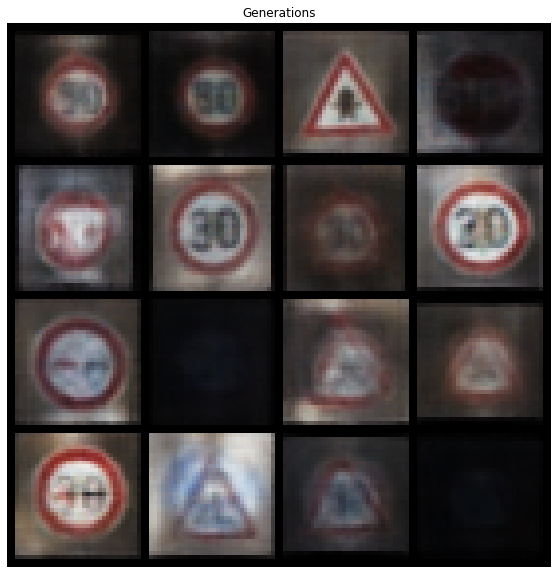

In [ ]:
generated_images = generate_images(model=vae, n_imgs=16, device=device)

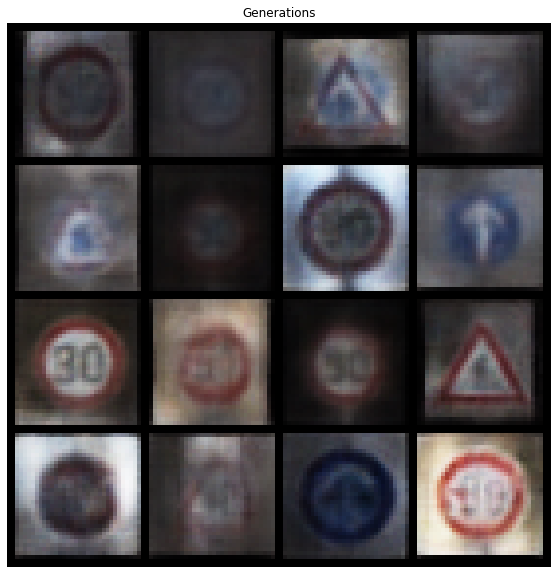

In [ ]:
generated_images = generate_images(model=big_vae, n_imgs=16, device=device)

In [ ]:
generated_images.size()

torch.Size([4, 3, 32, 32])

In [ ]:
!python -m pytorch_fid

/usr/bin/python3: No module named pytorch_fid
